# Model Run: Pair learning (Fixed length)
Version 1  
CNN + Mel.db.global-minmax

Version 2  


Version 3  
CNN + rawaudio

Version 6  
CNN + rawaudio + separate speakers

Version 8  
Further adjustments done to model to tackle overfitting

Version 8+  
Trying Melspectrogram, see whether it helps. 

Version 9  
Exclude AH, sp, spn, sil. 

Version 10  
I found that perhaps the difference in significance came from the difference in sample size, so this time try two things: use a subset of training set with the size of original validation set to check if the same data with smaller size can reach significance. Also, try to make validation set same size as training set. 

## Import Libs

In [43]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import torchmetrics.functional as tmf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, TimeMasking, FrequencyMasking
import random
from torchinfo import summary


from model_model import SiameseNetworkV2
from model_configs import ModelDimConfigs, TrainingConfigs
from misc_tools import get_timestamp
from model_dataset import Padder, DS_Tools, NormalizerKeepShape
from model_dataset import PairRecDatasetPregenPrecombineNoAH as ThisDataset
from model_loss import ContrastiveLoss, calculate_mean_ci
from model_filter import XpassFilter
from paths import *
from ssd_paths import *
from misc_progress_bar import draw_progress_bar
from misc_recorder import *

## Configure READ

In [2]:
READ = False

## Get Timestamp

In [3]:
if READ: 
    ts = "1113221926"
else: 
    ts = str(get_timestamp())
    # ts = "1128213823"

train_name = "cnn-pair-original-mel"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)
print(f"{train_name}-{ts}")

cnn-pair-original-mel-1205122639


In [4]:
stop_epoch = "99"
save_trainhist_name = "train.hst"
save_valhist_name = "val.hst"
# save_valprec_name = "valprec.hst"
# save_valrec_name = "valrec.hst"
# save_valf_name = "valf.hst"
val_same_name = "valsame.csv"
val_diff_name = "valdiff.csv"
train_same_name = "trainsame.csv"
train_diff_name = "traindiff.csv"

# val_pos_name = "valpos.hst"
# val_neg_name = "valneg.hst"

## Prepare Loss Recording

In [5]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_same = DfRecorder(os.path.join(model_save_dir, val_same_name))
valid_diff = DfRecorder(os.path.join(model_save_dir, val_diff_name))
train_same = DfRecorder(os.path.join(model_save_dir, train_same_name))
train_diff = DfRecorder(os.path.join(model_save_dir, train_diff_name))
# valid_precs = ListRecorder(os.path.join(model_save_dir, save_valprec_name))
# valid_recs = ListRecorder(os.path.join(model_save_dir, save_valrec_name))
# valid_fs = ListRecorder(os.path.join(model_save_dir, save_valf_name))

# valid_pos = ListRecorder(os.path.join(model_save_dir, val_pos_name))
# valid_neg = ListRecorder(os.path.join(model_save_dir, val_neg_name))

## Prepare Dataset

In [6]:
LOAD = False

In [8]:
# mytrans = MelSpecTransform(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
#                             n_fft=TrainingConfigs.N_FFT, 
#                             n_mels=TrainingConfigs.N_MELS, 
#                             filter=XpassFilter(cut_off_upper=500))
mytrans = nn.Sequential(
    Padder(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, pad_len_ms=250, noise_level=1e-4), 
    MelSpectrogram(sample_rate=TrainingConfigs.REC_SAMPLE_RATE, 
                   n_mels=TrainingConfigs.N_MELS, 
                   n_fft=TrainingConfigs.N_FFT, power=2), 
    # TimeMasking(time_mask_param=5), 
    # FrequencyMasking(freq_mask_param=16), 
    AmplitudeToDB(stype="power", top_db=80), 
    NormalizerKeepShape(NormalizerKeepShape.norm_mvn)
)
ori_train_ds = ThisDataset(strain_cut_audio_, os.path.join(suse_, "guide_train.csv"), 
                 list_save_dir=os.path.join(model_save_dir, "train_paired_list.csv"), 
                 total_number=20000, transform=mytrans, 
                 whether_load_from=LOAD, 
                 load_from=os.path.join(model_save_dir, "train_paired_list.csv"))

# valid_ds = ThisDataset(strain_cut_audio_, os.path.join(suse_, "guide_validation.csv"), 
#                  list_save_dir=os.path.join(model_save_dir, "valid_paired_list.csv"), 
#                  total_number=5000, transform=mytrans, 
#                  whether_load_from=LOAD,
#                  load_from=os.path.join(model_save_dir, "valid_paired_list.csv"))

use_len = int(0.7 * len(ori_train_ds))
remain_len = len(ori_train_ds) - use_len
train_ds, valid_ds = random_split(ori_train_ds, [use_len, remain_len])

# if not READ: 
#     # use_len = int(0.01 * len(ds))
#     # remain_len = len(ds) - use_len
#     # use_ds, remain_ds = random_split(ds, [use_len, remain_len])
#     # use_ds = ds

#     # train_len = int(0.8 * len(use_ds))
#     # valid_len = len(use_ds) - train_len

#     # Randomly split the dataset into train and validation sets
#     # train_ds, valid_ds = random_split(use_ds, [train_len, valid_len])

#     # NOTE: we don't need to save the cut-small subset, because after cutting-small, 
#     # the saved train and valid separations will reflect this
#     DS_Tools.save_indices(os.path.join(model_save_dir, "train.data"), train_ds.indices)
#     DS_Tools.save_indices(os.path.join(model_save_dir, "valid.data"), valid_ds.indices)
# else: 
#     train_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "train.data"))
#     valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.data"))

#     train_ds = torch.utils.data.Subset(ds, train_ds_indices)
#     valid_ds = torch.utils.data.Subset(ds, valid_ds_indices)

# TrainingConfigs.BATCH_SIZE
BATCH_SIZE = 64

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=TrainingConfigs.LOADER_WORKER) # collate_fn=ThisDataset.collate_fn)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          num_workers=TrainingConfigs.LOADER_WORKER) # collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)
print(train_num, valid_num)

14000 6000


In [9]:
# # Load sample data from train_loader
# sample_data = next(iter(valid_loader))
# x_1, x_2, seg = sample_data

# # Set the random seed for reproducibility
# # random.seed(101)
# # Generate six random indices
# random_indices = random.sample(range(len(x_1)), 6)

# # Plot the spectrograms and mark the corresponding seg
# fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# axes = axes.flatten()

# for i, idx in enumerate(random_indices):
#     spectrogram = x_1[idx]
#     segment = seg[idx]
    
#     ax = axes[i]
#     img = ax.plot(spectrogram[0].numpy())
#     # ax.axvline(x=segment, color='red', linestyle='--')
#     # ax.axvline(x=segment[1], coloFalser='red', linestyle='--')
#     ax.set_title(f'Spectrogram {segment}')
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Amplitude')
# plt.tight_layout()
# # plt.colorbar(img,ax=axes)
# plt.show()

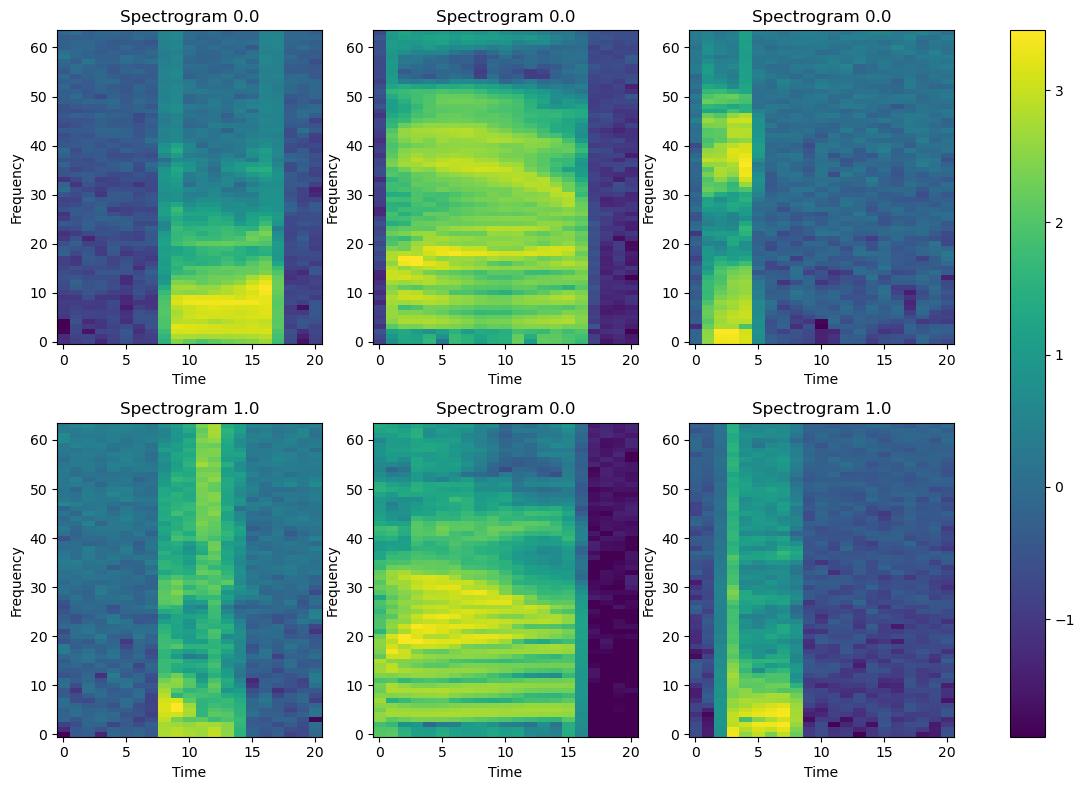

In [10]:
# Load sample data from train_loader
sample_data = next(iter(valid_loader))
x_1, x_2, seg = sample_data
# Set the random seed for reproducibility
random.seed(101)
# Generate six random indices
random_indices = random.sample(range(len(x_1)), 6)

# Plot the spectrograms and mark the corresponding seg
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    spectrogram = x_1[idx]
    segment = seg[idx]
    
    ax = axes[i]
    img = ax.imshow(spectrogram[0], aspect='auto', origin="lower")
    # ax.axvline(x=segment, color='red', linestyle='--')
    # ax.axvline(x=segment[1], color='red', linestyle='--')
    ax.set_title(f'Spectrogram {segment}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.colorbar(img,ax=axes)
plt.show()

## Init Model

In [11]:
# class SiameseNetworkV3(nn.Module):
#     # CNN version for siamese network
#     # output shape: (batch_size, 128)
#     def __init__(self, dimconf):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv1d(1, 128, kernel_size=244, stride=4), 
#             nn.MaxPool1d(kernel_size=4), 
#             nn.ReLU(), 
#             # nn.Dropout(0.75),
#             nn.BatchNorm1d(128), 
            
#             nn.Conv1d(128, 256, kernel_size=3), 
#             nn.MaxPool1d(kernel_size=4),
#             nn.ReLU(), 
#             # nn.Dropout(0.75),
#             nn.BatchNorm1d(256), 
            
#             nn.Conv1d(256, 512, kernel_size=3), 
#             nn.MaxPool1d(kernel_size=4), 
#             nn.ReLU(), 
#             # nn.Dropout(0.75),
#             nn.BatchNorm1d(512), 
#         )
#         self.ap = nn.AdaptiveAvgPool1d(output_size=1)
#         # self.dropout = nn.Dropout(dimconf["dropout"])
#         self.lin = nn.Linear(in_features=512, out_features=64)
#         # self.sigmoid = nn.Sigmoid()

#         self.conv.apply(self.init_conv_weights)
#         self.lin.apply(self.init_lin_weights)

#     def init_lin_weights(self, m):
#         if isinstance(m, nn.Linear):
#             # torch.nn.init.xavier_normal_(m.weight)
#             torch.nn.init.kaiming_normal_(m.weight, a=0.1)
#             m.bias.data.fill_(0.01)
    
#     def init_conv_weights(self, m):
#         if isinstance(m, nn.Conv2d):
#             torch.nn.init.kaiming_normal_(m.weight, a=0.1)
#             m.bias.data.zero_()

#     def forward_once(self, x):
#         # print(x[0])
#         x = self.conv(x)
#         # print(x[0])
#         x = self.ap(x)
#         # print(x.shape)
#         x = x.view(x.shape[0], -1)
#         # x = self.dropout(x)
#         # print(x.shape)
#         x = self.lin(x)
#         # x = self.sigmoid(x)
#         # print(x[0])
#         return x

#     def forward(self, inputs):
#         input1, input2 = inputs
#         # input1_lens, input2_lens = inputs_lens
#         # get two images' features
#         output1 = self.forward_once(input1)
#         output2 = self.forward_once(input2)
#         return output1, output2

#     def predict_on_output(self, output1, output2, threshold=0.5): 
#         output1 = output1.clone().detach()
#         output2 = output2.clone().detach()
#         euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
#         preds = (euclidean_distance >= threshold).type(torch.float32)
#         return preds

In [12]:
summary(nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(128), ), input_size=(128, 1, 64, 21))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [128, 128, 16, 5]         --
├─Conv2d: 1-1                            [128, 32, 64, 21]         320
├─MaxPool2d: 1-2                         [128, 32, 32, 10]         --
├─ReLU: 1-3                              [128, 32, 32, 10]         --
├─BatchNorm2d: 1-4                       [128, 32, 32, 10]         64
├─Conv2d: 1-5                            [128, 128, 32, 10]        36,992
├─MaxPool2d: 1-6                         [128, 128, 16, 5]         --
├─ReLU: 1-7                              [128, 128, 16, 5]         --
├─BatchNorm2d: 1-8                       [128, 128, 16, 5]         256
Total params: 37,632
Trainable params: 37,632
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.57
Input size (MB): 0.69
Forward/backward pass size (MB): 106.95
Params size (MB): 0.15
Estimated Total Size (MB): 107.79

In [13]:
"""
nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(16), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(64), 
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(256), 
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(512), 
        )

            nn.Conv2d(1, 32, kernel_size=(7, 3), stride=1, padding=(3, 1)), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 128, kernel_size=(7, 3), stride=1, padding=(3, 1)), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(128), 
            nn.Conv2d(128, 512, kernel_size=(7, 3), stride=1, padding=(3, 1)), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.ReLU(), 
            nn.BatchNorm2d(512), 
"""


class SiameseNetworkV3(nn.Module):
    # CNN version for siamese network
    # output shape: (batch_size, 128)
    def __init__(self, dimconf:ModelDimConfigs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(16, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        # self.lin_ld = nn.Linear(in_features=16 * 5, out_features=1)
        self.lin = nn.Linear(in_features=256, out_features=64)
        # self.lin2 = nn.Linear(in_features=128, out_features=64)
        # self.dropout = nn.Dropout(dimconf["dropout"])

        self.conv.apply(self.init_conv_weights)
        self.lin.apply(self.init_lin_weights)

    def init_lin_weights(self, m):
        if isinstance(m, nn.Linear):
            # torch.nn.init.xavier_normal_(m.weight)
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.fill_(0.01)
    
    def init_conv_weights(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, a=0.1)
            m.bias.data.zero_()

    def forward_once(self, x):
        # print(x[0])
        x = self.conv(x)
        # print(x[0])
        x = self.ap(x)
        # x = x.view(x.shape[0], x.shape[1], -1)
        # x = self.lin_ld(x)
        # x = self.dropout(x)
        # print(x[0])
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        # x = self.dropout(x)
        # x = self.lin2(x)
        # print(x[0])
        return x

    def forward(self, inputs):
        input1, input2 = inputs
        # input1_lens, input2_lens = inputs_lens
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def predict_on_output(self, output1, output2, threshold=0.5): 
        output1 = output1.clone().detach()
        output2 = output2.clone().detach()
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        # euclidean_distance = F.cosine_similarity(output1, output2, dim=1, eps=1e-6)
        preds = (euclidean_distance >= threshold).type(torch.float32)
        return preds

In [52]:
# x = torch.tensor([[1., 1.], [0., 0.]])
# y = torch.tensor([[0., 0.], [0., 0.]])
# tmf.pairwise_manhattan_distance(x, y, reduction="mean")
# # F.pairwise_distance(x, y, keepdim = False)

tensor([2., 0.])

In [53]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        # euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        euclidean_distance = tmf.pairwise_manhattan_distance(output1, output2, reduction="mean")
        # euclidean_distance = F.cosine_similarity(output1, output2, dim=1, eps=1e-6)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.MSELoss()
criterion = ContrastiveLoss(margin=1.0)
# criterion = nn.CrossEntropyLoss()
# NOTE: no need to mask the loss, because we don't do reconstruction. 

# dimconf = ModelDimConfigs(
#         rnn_in_size=TrainingConfigs.N_MELS, 
#         lin_in_size_1=16, 
#         lin_in_size_2=4, 
#         lin_out_size_2=1
#     )

dimconf = {
    "dropout": 0.5,
}

model = SiameseNetworkV3(
    dimconf=dimconf
)
# model = SiameseNetworkLinear(dimconf)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3) # weight_decay=l2_lambda

model_str = str(model)
model_txt_path = os.path.join(model_save_dir, "model.txt")

with open(model_txt_path, "w") as f:
    f.write(model_str)

### Test the relative size of loss: really-same-class different representations vs really-diff-class same reps
Representation dim will affect it. 

In [55]:
feats = 32
i1 = torch.rand(1, feats)
i2 = torch.rand(1, feats)

In [62]:
criterion = ContrastiveLoss(margin=10)
# 让不同的向量距离越大越好、相同的向量距离越小越好
criterion(i1, i1, 1), criterion(i1, i2, 0), criterion(i1, i1, 0), criterion(i1, i2, 1)

(tensor(10.), tensor(9.1200), tensor(0.), tensor(0.8800))

In [63]:
model

SiameseNetworkV3(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ap): AdaptiveAvgPool2d(output_size=1)
  (lin): Linear(in_features=256, out_features=32, bias=True)
)

## Load Model if READ

In [64]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

In [65]:
def evaluate_pair(output1,output2,target,threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    # if target == 1:
    #     return euclidean_distance > threshold
    # else:
    #     return euclidean_distance <= threshold
    # print(euclidean_distance)
    # raise Exception("stop")
    cond = euclidean_distance<threshold
    # print(cond)
    pos_sum = 0
    neg_sum = 0
    pos_acc = 0
    neg_acc = 0

    for i in range(len(cond)):
        if target[i]:
            neg_sum+=1
            if not cond[i]:
                neg_acc+=1
        if not target[i]:
            pos_sum+=1
            if cond[i]:
                pos_acc+=1

    return pos_acc,pos_sum,neg_acc,neg_sum


def draw_learning_curve_and_dissimilarity(losses, dissimilarities, epoch="", save=False, save_name=""): 
    plt.clf()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    train_losses, valid_losses, best_val_loss = losses
    # NOTE: !
    train_same_dict, train_diff_dict, same_dict, diff_dict, (draw_low, draw_up) = dissimilarities

    # time_steps = np.arange(draw_low, draw_up)
    # Plot Loss on the left subplot
    # ax1.plot(time_steps, train_losses[draw_low:draw_up], label='Train')
    # ax1.plot(time_steps, valid_losses[draw_low:draw_up], label='Valid')
    ax1.plot(train_losses, label='Train')
    ax1.plot(valid_losses, label='Valid')
    # ax1.axvline(x=best_val_loss, color='r', linestyle='--', label=f'Best: {best_val_loss}')
    ax1.set_title("Learning Curve Loss" + f" {epoch}")
    ax1.set_xlabel("Epoch" + f" (Best: {best_val_loss})")
    ax1.legend(loc="upper right")

    # Plot Accuracy on the right subplot
    time_steps = np.arange(draw_low, draw_up)
    ax2.errorbar(time_steps, same_dict["mean"][draw_low:draw_up], 
                 yerr=(same_dict["mean"][draw_low:draw_up] - same_dict["ci_lower"][draw_low:draw_up], same_dict["ci_upper"][draw_low:draw_up] - same_dict["mean"][draw_low:draw_up]), 
                 label='Same', fmt='o-', capsize=5)
    ax2.errorbar(time_steps, diff_dict["mean"][draw_low:draw_up], 
                 yerr=(diff_dict["mean"][draw_low:draw_up] - diff_dict["ci_lower"][draw_low:draw_up], diff_dict["ci_upper"][draw_low:draw_up] - diff_dict["mean"][draw_low:draw_up]), 
                 label='Different', fmt='o-', capsize=5)
    ax2.set_title('Learning Curve Valid Dissimilarity' + f" {epoch}")
    ax2.legend()    # loc="lower right"

    # Plot Accuracy on the right subplot
    time_steps = np.arange(draw_low, draw_up)
    ax3.errorbar(time_steps, train_same_dict["mean"][draw_low:draw_up], 
                 yerr=(train_same_dict["mean"][draw_low:draw_up] - train_same_dict["ci_lower"][draw_low:draw_up], train_same_dict["ci_upper"][draw_low:draw_up] - train_same_dict["mean"][draw_low:draw_up]), 
                 label='Same', fmt='o-', capsize=5)
    ax3.errorbar(time_steps, train_diff_dict["mean"][draw_low:draw_up], 
                 yerr=(train_diff_dict["mean"][draw_low:draw_up] - train_diff_dict["ci_lower"][draw_low:draw_up], train_diff_dict["ci_upper"][draw_low:draw_up] - train_diff_dict["mean"][draw_low:draw_up]), 
                 label='Different', fmt='o-', capsize=5)
    ax3.set_title('Learning Curve Train Dissimilarity' + f" {epoch}")
    ax3.legend()    # loc="lower right"

    # Display the plots
    plt.tight_layout()
    plt.xlabel("Epoch")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    if save: 
        plt.savefig(save_name)

In [66]:
EPOCHS = 50
BASE = 0

THRESHOLD = 4.5
criterion.margin

10

In [67]:
train_losses = ListRecorder(os.path.join(model_save_dir, save_trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, save_valhist_name))

valid_same = DfRecorder(os.path.join(model_save_dir, val_same_name))
valid_diff = DfRecorder(os.path.join(model_save_dir, val_diff_name))
train_same = DfRecorder(os.path.join(model_save_dir, train_same_name))
train_diff = DfRecorder(os.path.join(model_save_dir, train_diff_name))

In [68]:
def train(): 
    best_valid_loss = 1e9
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader)    # train_loader
        train_dissimilarities = []
        train_targets = []
        for idx, (x_1, x_2, y) in enumerate(train_loader):
            optimizer.zero_grad()
            # print(x_1)
            
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            y = torch.tensor(y, device=device, dtype=torch.float32)

            o1, o2 = model((x_1, x_2))
            # y_hat = y_hat.squeeze(dim=1)
            # euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)
            # loss = criterion(euclidean_distance, y)
            loss = criterion(o1, o2, y)
            # print(o1, o2)
            # print(loss.item())
            # raise Exception("stop")

            # # L2 regularization term
            # l2_reg = torch.tensor(0., device=device)
            # for param in model.parameters():
            #     l2_reg += torch.norm(param)

            # # Add L2 regularization to the loss
            # loss += l2_lambda * l2_reg

            train_loss += loss.item()

            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=4, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()

            o1 = o1.clone().detach()
            o2 = o2.clone().detach()
            euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)
            # euclidean_distance = F.cosine_similarity(o1, o2, dim=1, eps=1e-6)
            train_dissimilarities += euclidean_distance.cpu().tolist()
            train_targets += y.cpu().tolist()

            draw_progress_bar(idx, train_num, title="Train")

        train_losses.append(train_loss / train_num)
        train_same_preds, train_diff_preds = calculate_mean_ci(train_dissimilarities, train_targets)
        train_same.append(train_same_preds)
        train_diff.append(train_diff_preds)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader)
        # val_pos_accuracy = 0
        # val_neg_accuracy = 0
        # num_pos = 0
        # num_neg = 0
        valid_dissimilarities = []
        valid_targets = []
        with torch.no_grad():
            for idx, (x_1, x_2, y) in enumerate(valid_loader):
                x_1 = x_1.to(device)
                x_2 = x_2.to(device)
                # print(x_1, x_2)
                y = torch.tensor(y, device=device, dtype=torch.float32)

                o1, o2 = model((x_1, x_2))
                # y_hat = y_hat.squeeze(dim=1)
                # print(o1, o2)
                # euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)
                # loss = criterion(euclidean_distance, y)
                loss = criterion(o1, o2, y)

                # # L2 regularization term
                # l2_reg = torch.tensor(0., device=device)
                # for param in model.parameters():
                #     l2_reg += torch.norm(param)

                # # Add L2 regularization to the loss
                # loss += l2_lambda * l2_reg

                # print(o1, o2)
                # print(loss.item())
                valid_loss += loss.item()

                o1 = o1.clone().detach()
                o2 = o2.clone().detach()
                euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)
                # euclidean_distance = F.cosine_similarity(o1, o2, dim=1, eps=1e-6)
                valid_dissimilarities += euclidean_distance.cpu().tolist()
                valid_targets += y.cpu().tolist()
                # print(euclidean_distance)
                # raise Exception("stop")

                # pos_acc,pos_sum,neg_acc,neg_sum = evaluate_pair(o1, o2, y, THRESHOLD)
                # val_pos_accuracy+=pos_acc
                # val_neg_accuracy+=neg_acc
                # num_pos+=pos_sum
                # num_neg+=neg_sum
                # euclidean_distance = F.pairwise_distance(o1, o2, keepdim = False)

                # pred = model.predict_on_output(o1, o2, threshold=THRESHOLD)

                # valid_preds += pred.cpu().tolist()
                # valid_targets += y.cpu().tolist()

                # draw_progress_bar(idx, valid_num, title="Valid")

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        # val_pos_accuracy /= num_pos
        # val_neg_accuracy /= num_neg

        valid_same_preds, valid_diff_preds = calculate_mean_ci(valid_dissimilarities, valid_targets)
        valid_same.append(valid_same_preds)
        valid_diff.append(valid_diff_preds)
        
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve_and_dissimilarity(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                                dissimilarities=(train_same.get(), train_diff.get(), valid_same.get(), valid_diff.get(), (max(epoch - 10, 0), epoch)),
                                                epoch=str(epoch))
        train_losses.save()
        valid_losses.save()
        valid_same.save()
        valid_diff.save()
        train_same.save()
        train_diff.save()
    
    return best_valid_loss_epoch

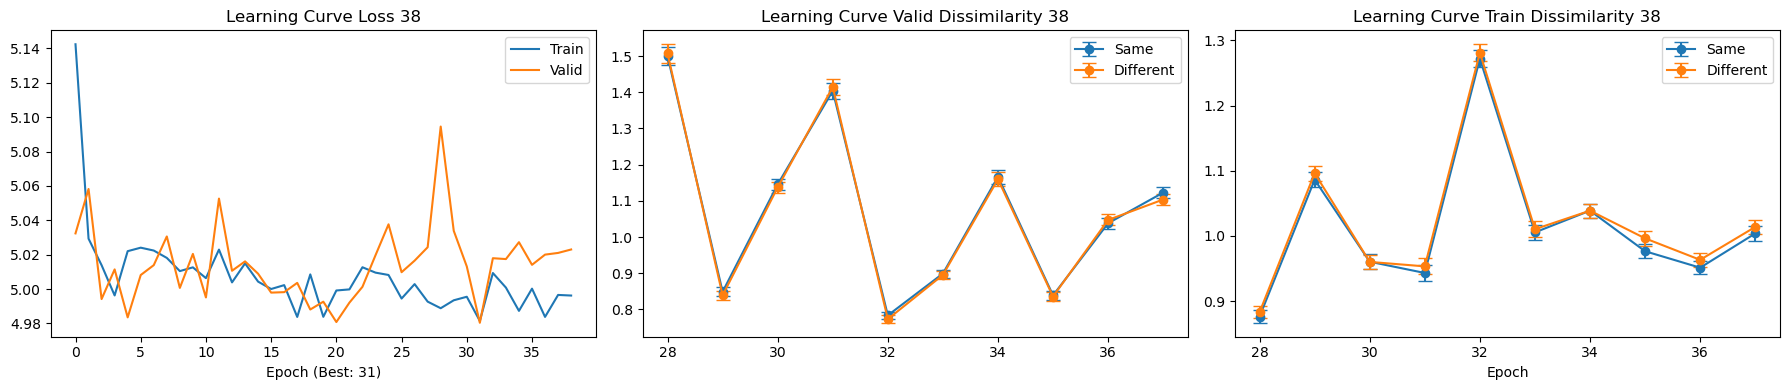

Train [======                                            ] 11%

/tmp/ipykernel_2514021/4041338728.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, device=device, dtype=torch.float32)


Train [==================================================] 99%

In [69]:
if __name__ == "__main__": 
    best_valid_loss_epoch = train()
    draw_learning_curve_and_dissimilarity(losses=(train_losses.get(), valid_losses.get(), best_valid_loss_epoch), 
                                        dissimilarities=(train_same.get(), train_diff.get(), valid_same.get(), valid_diff.get(), (0, BASE + EPOCHS)),
                                        epoch=str(BASE + EPOCHS - 1), 
                                        save=True, 
                                        save_name=f"{model_save_dir}/vis.png")